In [2]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

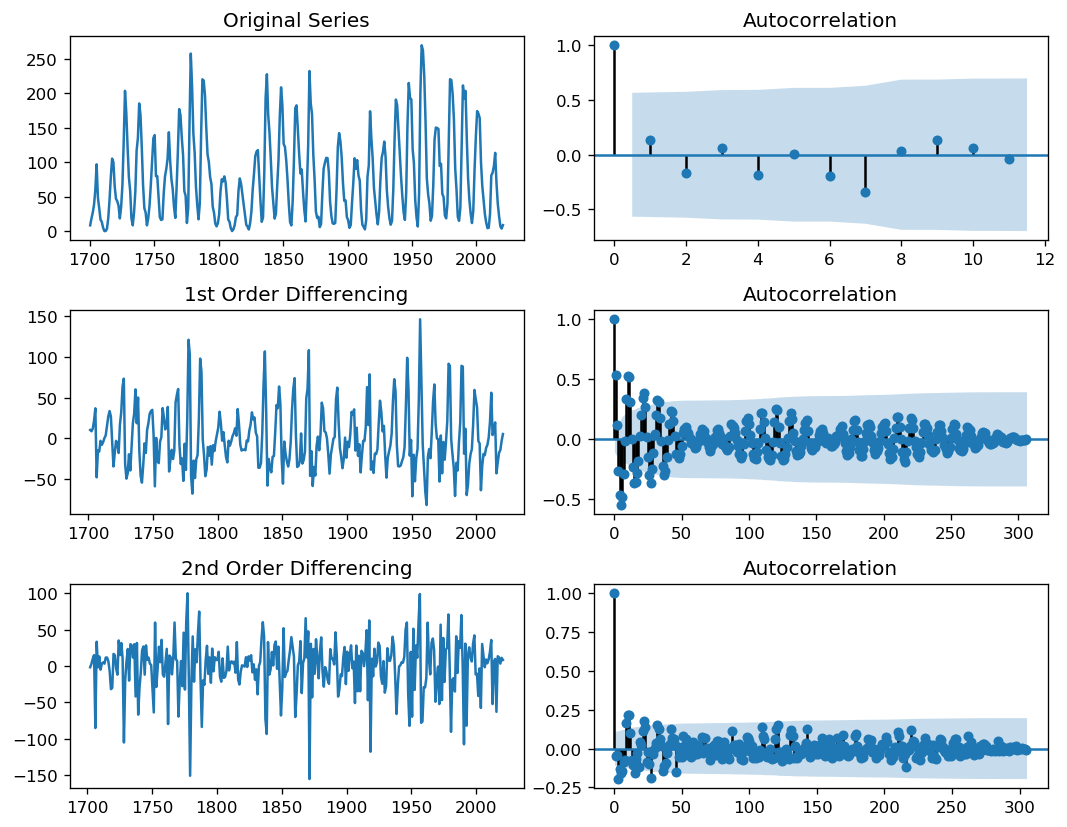

In [4]:
# Step 1: How to find the order of differencing (d) in ARIMA model
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
df1= pd.read_fwf('SN_y_tot_V2.0.txt',header=None)
tmp=[]
time=df1[0].tolist()
R=df1[1].tolist()
for i in range(len(time)):
    tmp.append([time[i],R[i]])
df = pd.DataFrame(tmp, columns=["time", "value"]).set_index('time')

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(x=np.array([23.32, 32.33, 32.88, 28.98, 33.16, 26.33, 29.88, 32.69, 18.98, 21.23, 26.66, 29.89]),ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), lags=np.arange(307), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), lags=np.arange(306), ax=axes[2, 1])
plt.tight_layout()
plt.show()

# The time series reaches stationarity with two orders of differencing.
# The autocorrelation plot for the 2nd differencing shows:
# The lag goes into the far negative zone fairly quick.
# The series might have been over differenced.
# So, let us, tentatively, fix the order of differencing d = 1



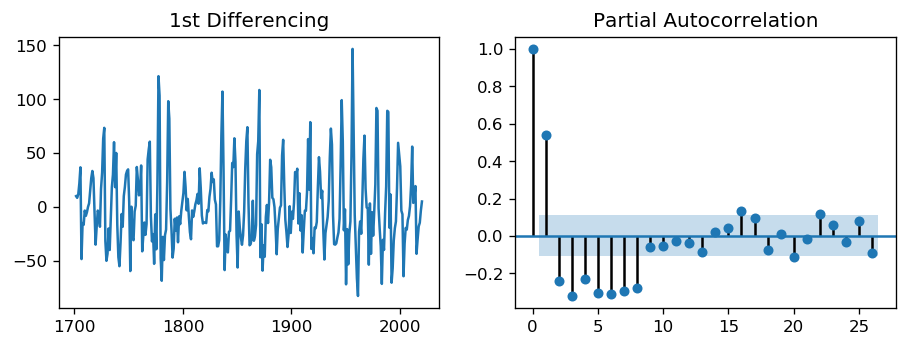

In [3]:
# Step 2: How to find the order of the AR term (p)

# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

# The required number of AR terms can be determined by inspecting the (PACF) plot.
# Any autocorrelation in a stationarized series can be rectified by adding enough AR terms.
# The PACF lag 1 is quite significant since is well above the significance line (blue region).
# Lag 2 turns out to be significant as well, slightly managing to cross the significance limit.
# But let us be conservative and tentatively fix p = 8.



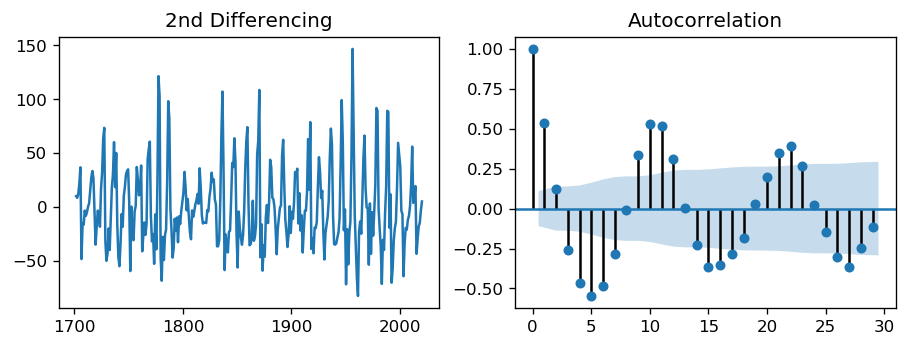

In [4]:

# Step 3: How to find the order of the MA term (q)

import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data
fig, axes = plt.subplots(1, 2)
axes[0].plot(df.value.diff()); axes[0].set_title('2nd Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1],lags=np.arange(30))

plt.show()

# Couple of lags are well above the significance line.
# So, let’s tentatively fix q = 2.
# When in doubt, go with the simpler model that sufficiently explains the Y.



In [5]:
df_pred= pd.read_fwf('SN_y_tot_V2.0.txt',header=None)
act_data=df_pred[1].tolist()

C:\Users\saris\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\saris\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  320
Model:                 ARIMA(8, 1, 2)   Log Likelihood               -1467.894
Method:                       css-mle   S.D. of innovations             23.650
Date:                Fri, 12 Mar 2021   AIC                           2959.787
Time:                        06:59:33   BIC                           3005.007
Sample:                             1   HQIC                          2977.844
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0390      0.472      0.083      0.934      -0.885       0.963
ar.L1.D.value     0.2257      0.316      0.713      0.476      -0.394       0.846
ar.L2.D.value    -0.0728      0.276     

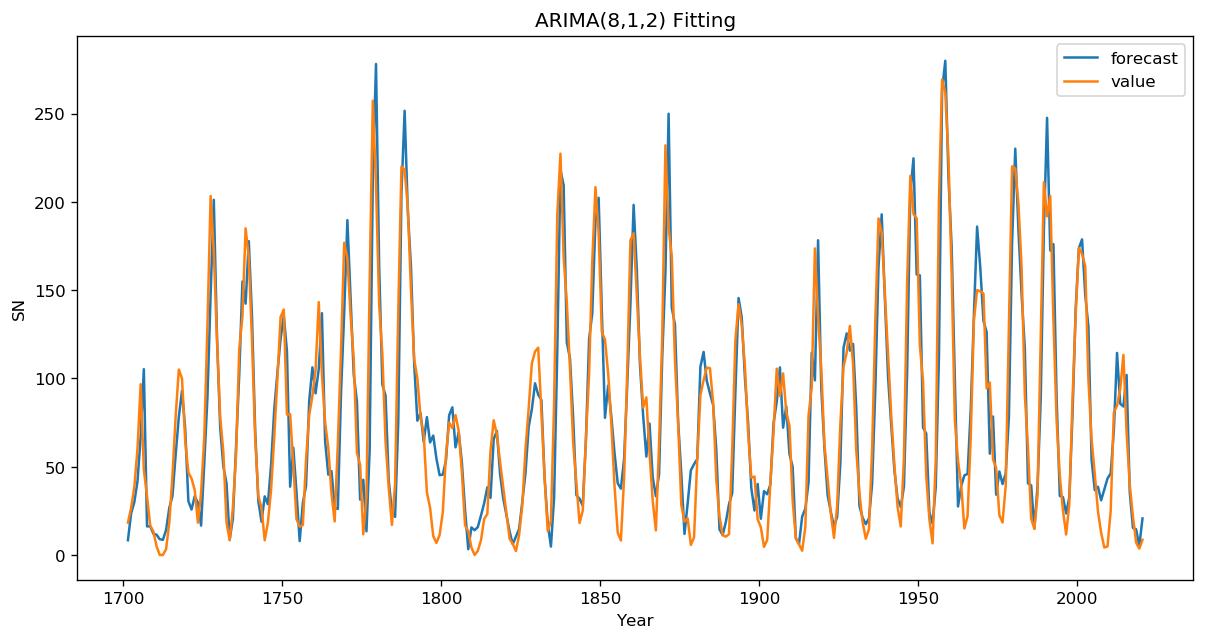

In [6]:
# Step 4: How to build the ARIMA Model

from statsmodels.tsa.arima_model import ARIMA

# p,d,q ARIMA Model
#model = ARIMA(df.value, order=(1,1,2))
#model_fit = model.fit(disp=0)
#print(model_fit.summary())

# 1,1,1 ARIMA Model
model = ARIMA(df.value, order=(8,1,2))
model_fit = model.fit()
print(model_fit.summary())

# Plot residual errors
#residuals = pd.DataFrame(model_fit.resid)
#fig, ax = plt.subplots(1,2)
#residuals.plot(title="Residuals", ax=ax[0])
#residuals.plot(kind='kde', title='Density', ax=ax[1])
#plt.show()

# Actual vs Fitted
fig, ax = plt.subplots(figsize=(12, 6))


model_fit.plot_predict(dynamic=False,ax=ax)
plt.ylabel("SN")
plt.xlabel("Year")
plt.title("ARIMA(8,1,2) Fitting")
plt.savefig('fitting.pdf')
plt.show()


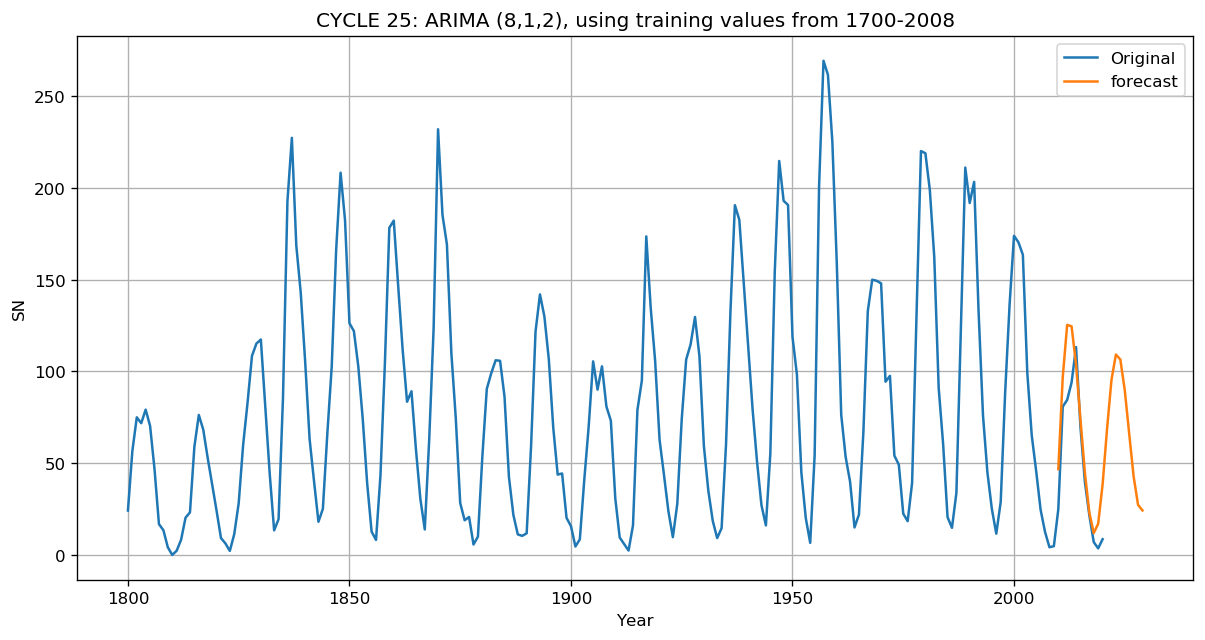

In [13]:
# Actual vs Fitted
fig, ax = plt.subplots(figsize=(12, 6))
forecast = model_fit.forecast(steps=20)
ax.plot(np.arange(100,321),act_data[100:],label='Original')
ax.plot(np.arange(310,330),forecast[0],label='forecast')
ax.set_xticklabels(range(1750,2001,50))
ax.grid()
plt.legend()
plt.title("CYCLE 25: ARIMA (8,1,2), using training values from 1700-2008")
plt.ylabel("SN")
plt.xlabel("Year")
plt.savefig('cycle25.pdf')
plt.show()


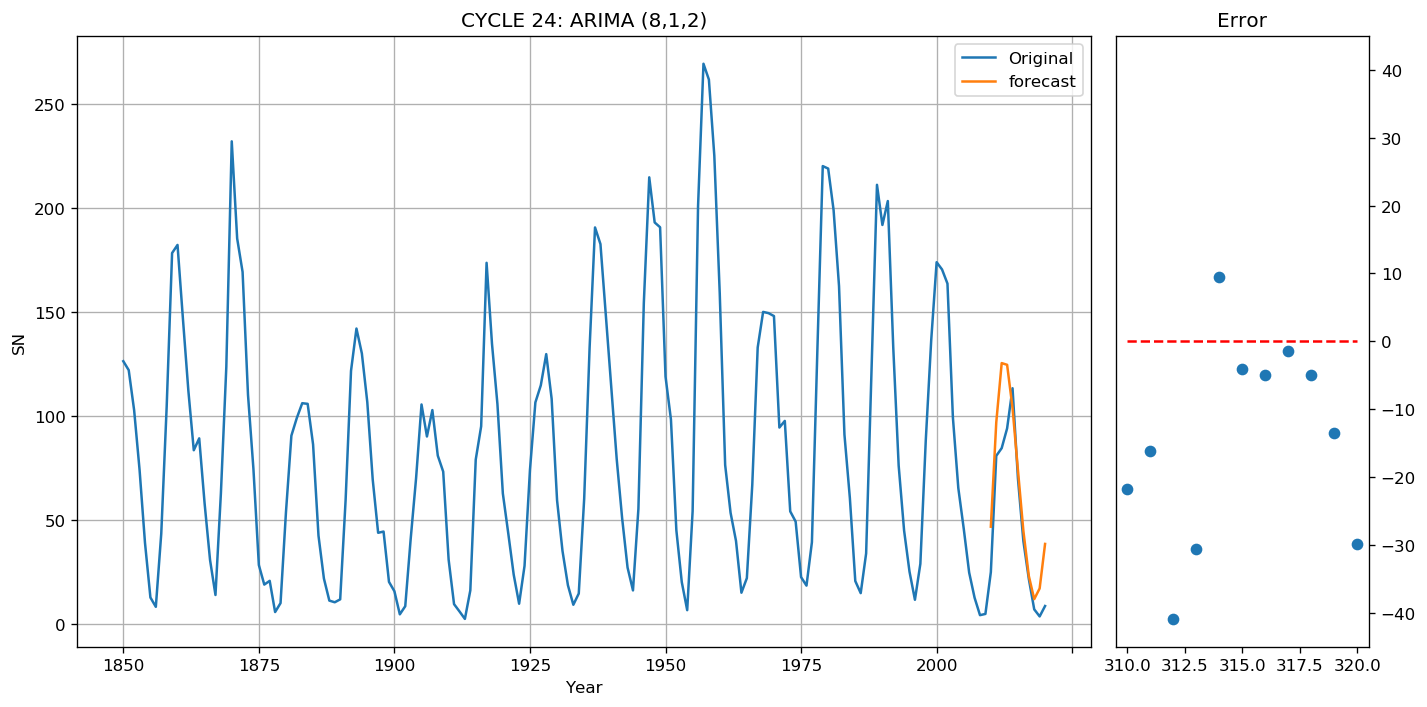

In [15]:
# Actual vs Fitted
from matplotlib import gridspec
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1]) 

ax=fig.add_subplot(gs[0])
forecast = model_fit.forecast(steps=11)
ax.plot(np.arange(150,321),act_data[150:],label='Original')
ax.plot(np.arange(310,321),forecast[0],label='forecast')
ax.set_xticklabels(range(1825,2001,25))
ax.grid()
plt.legend()
plt.title("CYCLE 24: ARIMA (8,1,2)")
plt.ylabel("SN")
plt.xlabel("Year")
err=fig.add_subplot(gs[1])

forecast = model_fit.forecast(steps=11)
err.scatter(np.arange(310,321),act_data[310:]-forecast[0])
err.plot(range(310,321),np.zeros(11),'r--')
err.set_ylim(-45,45)
err.yaxis.tick_right()
err.set_title("Error")

plt.tight_layout()
plt.savefig('cycle24.pdf')
plt.show()


In [ ]:
ax = res_111.plot_predict('2009', '2021', dynamic=True, plot_insample=False, ax=ax);

In [ ]:
tmp=[]
df1= pd.read_fwf('SN_y_tot_V2.0.txt',header=None)
tmp=[]
time=df1[0].tolist()
R=df1[1].tolist()
index= pd.date_range(start='1700', end='2021', freq='Y')

for i in range(len(index)):
    tmp.append([index[i],R[i]])

df = pd.DataFrame(tmp, columns=["time", "value"]).set_index('time')

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(np.log(df.data+1).dropna(), (8, 1, 1))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(np.log(df.data+1).dropna(), (3, 0, 2))
res_010 = model.fit()
print(res_010.summary())
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();

In [ ]:
model = ARIMA(np.log(df.data+1).dropna()[:-12], (8, 1, 1))
res_111 = model.fit()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
df.index = pd.to_datetime(df.index, format="%Y-%m")
np.log(df.data+1).dropna()[150:].plot(ax=ax);
ax.vlines('2009', 5.5, 1.5, linestyle='--', color='r', label='Start of forecast');

# - NOTE from the official documentation :
# -- The dynamic keyword affects in-sample prediction. 
# -- If dynamic is False, then the in-sample lagged values are used for prediction. 
# -- If dynamic is True, then in-sample forecasts are used in place of lagged dependent variables.
ax = res_010.plot_predict(1,320, dynamic=True, plot_insample=False, ax=ax);

In [ ]:
model2 = ARIMA(np.log(df.data+1).dropna()[:-12], (3, 0, 2))
res_121 = model.fit()

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

residuals = pd.DataFrame(res_121.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Actual vs Fitted
res_121.plot_predict()
plt.show()

In [11]:
act_data

[8.3,
 18.3,
 26.7,
 38.3,
 60.0,
 96.7,
 48.3,
 33.3,
 16.7,
 13.3,
 5.0,
 0.0,
 0.0,
 3.3,
 18.3,
 45.0,
 78.3,
 105.0,
 100.0,
 65.0,
 46.7,
 43.3,
 36.7,
 18.3,
 35.0,
 66.7,
 130.0,
 203.3,
 171.7,
 121.7,
 78.3,
 58.3,
 18.3,
 8.3,
 26.7,
 56.7,
 116.7,
 135.0,
 185.0,
 168.3,
 121.7,
 66.7,
 33.3,
 26.7,
 8.3,
 18.3,
 36.7,
 66.7,
 100.0,
 134.8,
 139.0,
 79.5,
 79.7,
 51.2,
 20.3,
 16.0,
 17.0,
 54.0,
 79.3,
 90.0,
 104.8,
 143.2,
 102.0,
 75.2,
 60.7,
 34.8,
 19.0,
 63.0,
 116.3,
 176.8,
 168.0,
 136.0,
 110.8,
 58.0,
 51.0,
 11.7,
 33.0,
 154.2,
 257.3,
 209.8,
 141.3,
 113.5,
 64.2,
 38.0,
 17.0,
 40.2,
 138.2,
 220.0,
 218.2,
 196.8,
 149.8,
 111.0,
 100.0,
 78.2,
 68.3,
 35.5,
 26.7,
 10.7,
 6.8,
 11.3,
 24.2,
 56.7,
 75.0,
 71.8,
 79.2,
 70.3,
 46.8,
 16.8,
 13.5,
 4.2,
 0.0,
 2.3,
 8.3,
 20.3,
 23.2,
 59.0,
 76.3,
 68.3,
 52.9,
 38.5,
 24.2,
 9.2,
 6.3,
 2.2,
 11.4,
 28.2,
 59.9,
 83.0,
 108.5,
 115.2,
 117.4,
 80.8,
 44.3,
 13.4,
 19.5,
 85.8,
 192.7,
 227.3,
 168.7,
 1

In [15]:
forecast

(array([ 46.73274309,  96.88976103, 125.38332277, 124.5686894 ,
        103.82792681,  73.84843934,  44.71031849,  23.08099619,
         11.90557237,  17.04846006,  38.44741509]),
 array([23.81190187, 36.96157963, 43.8458005 , 45.68800276, 45.93183827,
        45.936359  , 46.01740093, 46.06196348, 46.06296249, 46.43341946,
        48.27733479]),
 array([[ 6.22730248e-02,  9.34032132e+01],
        [ 2.44463961e+01,  1.69333126e+02],
        [ 3.94471329e+01,  2.11319513e+02],
        [ 3.50218495e+01,  2.14115529e+02],
        [ 1.38031781e+01,  1.93852676e+02],
        [-1.61851699e+01,  1.63882049e+02],
        [-4.54821300e+01,  1.34902767e+02],
        [-6.71987933e+01,  1.13360786e+02],
        [-7.83761751e+01,  1.02187320e+02],
        [-7.39593698e+01,  1.08056290e+02],
        [-5.61744224e+01,  1.33069253e+02]]))

In [ ]:
df.value[10].index

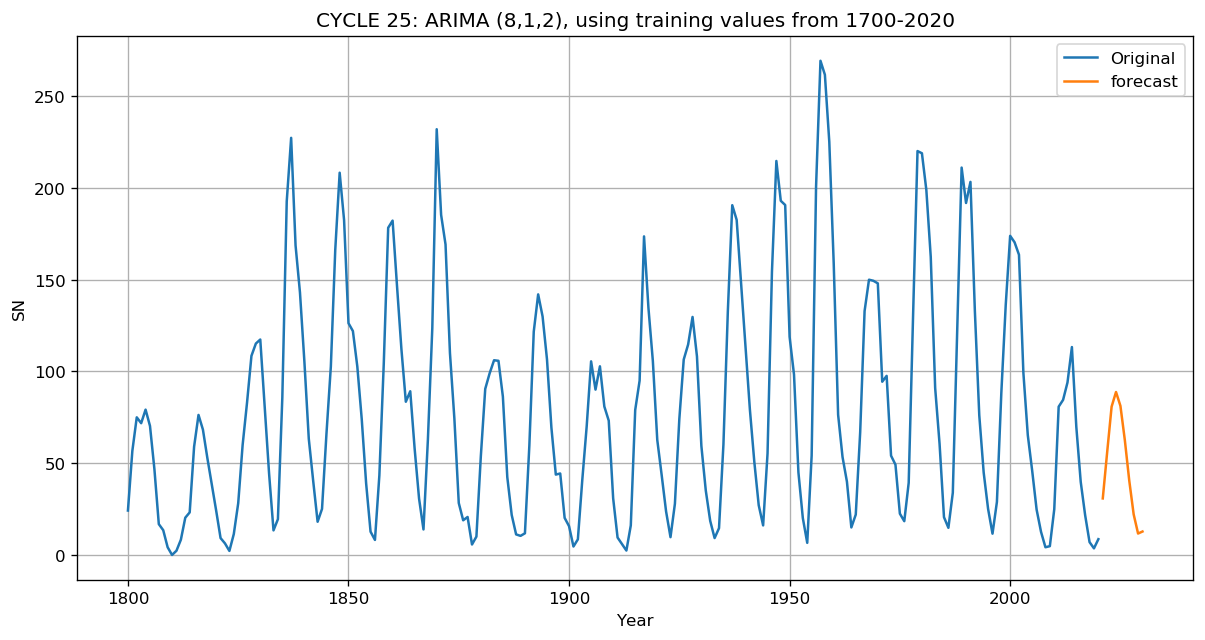

In [16]:
model = ARIMA(act_data, order=(8,1,2))
model_fit = model.fit()
fig, ax = plt.subplots(figsize=(12, 6))
forecast = model_fit.forecast(steps=10)
ax.plot(np.arange(100,321),act_data[100:],label='Original')
ax.plot(np.arange(321,331),forecast[0],label='forecast')
ax.set_xticklabels(range(1750,2001,50))
ax.grid()
plt.legend()
plt.title("CYCLE 25: ARIMA (8,1,2), using training values from 1700-2020")
plt.ylabel("SN")
plt.xlabel("Year")
plt.savefig('cycle25(2).pdf')
plt.show()


C:\Users\saris\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                  310
Model:                     ARMA(3, 2)   Log Likelihood               -1429.146
Method:                       css-mle   S.D. of innovations             24.180
Date:                Fri, 12 Mar 2021   AIC                           2872.291
Time:                        05:49:56   BIC                           2898.447
Sample:                             0   HQIC                          2882.748
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          77.2517      9.141      8.452      0.000      59.337      95.167
ar.L1.value     2.5506      0.034     75.206      0.000       2.484       2.617
ar.L2.value    -2.4511      0.057    -43.073    

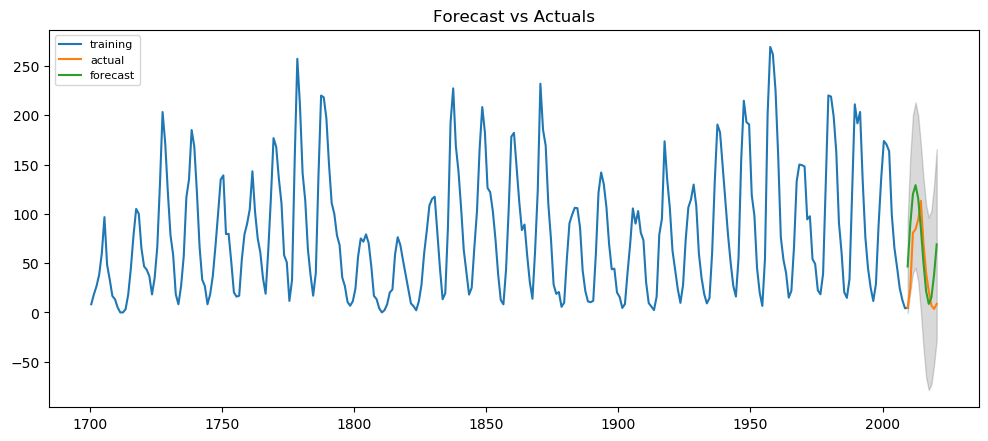

In [32]:
# Build Model
x=11
train = df.value[:2020.5-x]
test = df.value[2020.5-x:]
model = ARIMA(train, order=(3,0,2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(x+1, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

C:\Users\saris\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                  321
Model:                     ARMA(3, 2)   Log Likelihood               -1477.034
Method:                       css-mle   S.D. of innovations             23.973
Date:                Fri, 12 Mar 2021   AIC                           2968.067
Time:                        05:55:07   BIC                           2994.467
Sample:                             0   HQIC                          2978.608
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          75.8792      9.193      8.254      0.000      57.861      93.898
ar.L1.value     2.5525      0.033     78.278      0.000       2.489       2.616
ar.L2.value    -2.4534      0.055    -44.944    

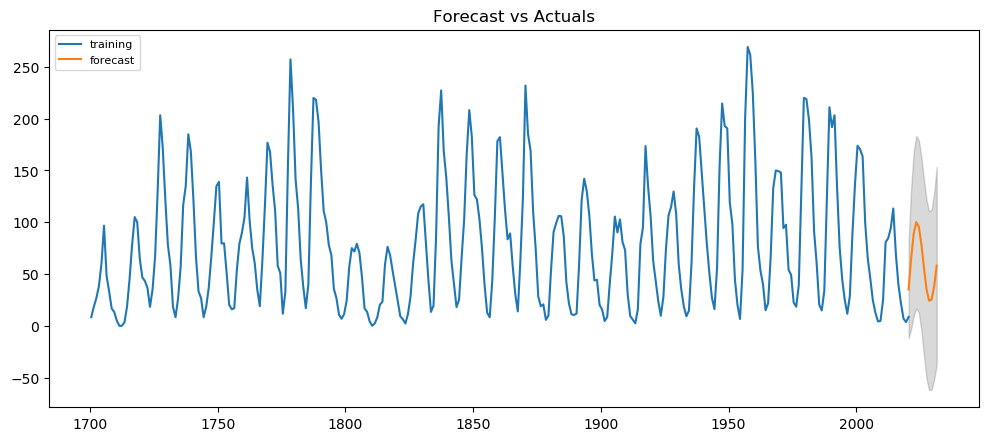

In [8]:
# Build Model
from statsmodels.tsa.arima_model import ARIMA
x=11
train = df.value

model = ARIMA(train, order=(3,0,2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(12, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=np.arange(2020.5,2021.5+x))
lower_series = pd.Series(conf[:, 0], index=np.arange(2020.5,2021.5+x))
upper_series = pd.Series(conf[:, 1], index=np.arange(2020.5,2021.5+x))

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [34]:
train

time
1700.5     8.3
1701.5    18.3
1702.5    26.7
1703.5    38.3
1704.5    60.0
          ... 
2016.5    39.8
2017.5    21.7
2018.5     7.0
2019.5     3.6
2020.5     8.6
Name: value, Length: 321, dtype: float64